# Using skorch with embeddings net for grid search

In [3]:
from shutil import rmtree
import IPython.display as ipd
import torch
from torch.utils.data import Dataset
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import glob
import librosa
from scipy.io import wavfile
import pandas as pd
import random
import os
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
from torch import nn
import torch.nn.functional as F
from tqdm import trange, tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

In [4]:
import sympy

sympy.init_printing()

from sympy import I, pi

In [5]:
I

In [6]:
pi

layers越多不一定越好

In [9]:
# Preprocessing Data
def save_spectrogram_tisv(audio_path, tisv_frame=180, hop=0.01, window=0.0025, sr=8000, nfft=512, nmels=40):
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set
    """
    print("start text independent utterance feature extraction")
    audio_path = glob.glob(os.path.dirname(audio_path))
    rmtree('./train_tisv/', ignore_errors=True)
    rmtree('./test_tisv/', ignore_errors=True)
    os.makedirs('./train_tisv', exist_ok=True)   # make folder to save train file
    os.makedirs('./test_tisv', exist_ok=True)    # make folder to save test file
    _no_sound_found = 0
    _minium_name_file_per_speaker = 10000
    utter_min_len = (tisv_frame * hop + window) * sr    # lower bound of utterance length
    total_speaker_num = len(audio_path)
    train_speaker_num= (total_speaker_num//10)*9            # split total data 90% train and 10% test
    print("total speaker number : %d"%total_speaker_num)
    print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    for i, folder in enumerate(audio_path):
        print("%dth speaker processing..."%i)
        utterances_spec = []
        for utter_name in os.listdir(folder):
            if utter_name[-4:] == '.wav':
                utter_path = os.path.join(folder, utter_name)         # path of each utterance
                utter, sr = librosa.core.load(utter_path, sr)        # load utterance audio
                intervals = librosa.effects.split(utter, top_db=30)         # voice activity detection
                for interval in intervals:
                    if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
                        utter_part = utter[interval[0]:interval[1]]         # save first and last 180 frames of spectrogram.
                        S = librosa.core.stft(y=utter_part, n_fft=nfft,
                                              win_length=int(window * sr), hop_length=int(hop * sr))
                        S = np.abs(S) ** 2
                        mel_basis = librosa.filters.mel(sr=sr, n_fft=nfft, n_mels=nmels)
                        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
                        utterances_spec.append(S[:, :tisv_frame])    # first 180 frames of partial utterance
                        utterances_spec.append(S[:, -tisv_frame:])   # last 180 frames of partial utterance

        utterances_spec = np.array(utterances_spec)
        if utterances_spec.shape[0] < 6:
            print(f"{i}th speaker {folder} not enough files")
            continue
        if utterances_spec.shape[0] < _minium_name_file_per_speaker:
            _minium_name_file_per_speaker = utterances_spec.shape[0]
        if i < train_speaker_num:
            np.save(os.path.join('./train_tisv', "speaker%d.npy" % i), utterances_spec)        
        else:
            np.save(os.path.join('./test_tisv', f"speaker{i-train_speaker_num}"), utterances_spec)
        print(utterances_spec.shape)

In [10]:
audio_path = '/storage/company_old/*/*.wav'
save_spectrogram_tisv(audio_path)

start text independent utterance feature extraction
total speaker number : 274
train : 243, test : 31
0th speaker processing...
(32, 40, 180)
1th speaker processing...
(34, 40, 180)
2th speaker processing...
(6, 40, 180)
3th speaker processing...
(26, 40, 180)
4th speaker processing...
(16, 40, 180)
5th speaker processing...
5th speaker /storage/company_old/C0743653663-C not enough files
6th speaker processing...
(22, 40, 180)
7th speaker processing...
(18, 40, 180)
8th speaker processing...
(32, 40, 180)
9th speaker processing...
(58, 40, 180)
10th speaker processing...
(14, 40, 180)
11th speaker processing...
(32, 40, 180)
12th speaker processing...
(24, 40, 180)
13th speaker processing...
(16, 40, 180)
14th speaker processing...
(32, 40, 180)
15th speaker processing...
(38, 40, 180)
16th speaker processing...
16th speaker /storage/company_old/C09037193889-C not enough files
17th speaker processing...
(44, 40, 180)
18th speaker processing...
(10, 40, 180)
19th speaker processing...
(

(34, 40, 180)
182th speaker processing...
(14, 40, 180)
183th speaker processing...
(18, 40, 180)
184th speaker processing...
(14, 40, 180)
185th speaker processing...
(22, 40, 180)
186th speaker processing...
(26, 40, 180)
187th speaker processing...
(34, 40, 180)
188th speaker processing...
188th speaker /storage/company_old/C08040284965-C not enough files
189th speaker processing...
(100, 40, 180)
190th speaker processing...
(26, 40, 180)
191th speaker processing...
(40, 40, 180)
192th speaker processing...
(46, 40, 180)
193th speaker processing...
(20, 40, 180)
194th speaker processing...
(28, 40, 180)
195th speaker processing...
(32, 40, 180)
196th speaker processing...
(20, 40, 180)
197th speaker processing...
(44, 40, 180)
198th speaker processing...
(32, 40, 180)
199th speaker processing...
(30, 40, 180)
200th speaker processing...
(44, 40, 180)
201th speaker processing...
(40, 40, 180)
202th speaker processing...
(14, 40, 180)
203th speaker processing...
(16, 40, 180)
204th sp

##### BUG
1. TypeError: 无法把网络放到gridsearch里面.
2. missing one parameter: embeddings in forward

In [11]:
def get_centroids(embeddings):
    centroids = embeddings.mean(dim=1)
    return centroids

def get_utterance_centroids(embeddings):
    """
    Returns the centroids for each utterance of a speaker, where
    the utterance centroid is the speaker centroid without considering
    this utterance

    Shape of embeddings should be:
    (speaker_ct, utterance_per_speaker_ct, embedding_size)
    """
    sum_centroids = embeddings.sum(dim=1)
    # we want to subtract out each utterance, prior to calculating the
    # the utterance centroid
    sum_centroids = sum_centroids.reshape(sum_centroids.shape[0], 1, sum_centroids.shape[-1])
    # we want the mean but not including the utterance itself, so -1
    num_utterances = embeddings.shape[1] - 1
    centroids = (sum_centroids - embeddings) / num_utterances
    return centroids

def get_cossim(embeddings, centroids):
    # number of utterances per speaker
    num_utterances = embeddings.shape[1]
    utterance_centroids = get_utterance_centroids(embeddings)

    # flatten the embeddings and utterance centroids to just utterance,
    # so we can do cosine similarity
    utterance_centroids_flat = utterance_centroids.view(utterance_centroids.shape[0] * utterance_centroids.shape[1],-1)
    embeddings_flat = embeddings.view(embeddings.shape[0] * num_utterances,-1)
    # the cosine distance between utterance and the associated centroids
    # for that utterance
    # this is each speaker's utterances against his own centroid, but each
    # comparison centroid has the current utterance removed
    cos_same = F.cosine_similarity(embeddings_flat, utterance_centroids_flat)

    # now we get the cosine distance between each utterance and the other speakers'
    # centroids
    # to do so requires comparing each utterance to each centroid. To keep the
    # operation fast, we vectorize by using matrices L (embeddings) and
    # R (centroids) where L has each utterance repeated sequentially for all
    # comparisons and R has the entire centroids frame repeated for each utterance
    centroids_expand = centroids.repeat((num_utterances * embeddings.shape[0], 1))
    embeddings_expand = embeddings_flat.unsqueeze(1).repeat(1, embeddings.shape[0], 1)
    embeddings_expand = embeddings_expand.view(embeddings_expand.shape[0] * embeddings_expand.shape[1],embeddings_expand.shape[-1])
    cos_diff = F.cosine_similarity(embeddings_expand, centroids_expand)
    cos_diff = cos_diff.view(embeddings.size(0),num_utterances,centroids.size(0))
    # assign the cosine distance for same speakers to the proper idx
    same_idx = list(range(embeddings.size(0)))
    cos_diff[same_idx, :, same_idx] = cos_same.view(embeddings.shape[0], num_utterances)
    cos_diff = cos_diff + 1e-6
    return cos_diff

def calc_loss(sim_matrix):
    same_idx = list(range(sim_matrix.size(0)))
    pos = sim_matrix[same_idx, :, same_idx]
    neg = (torch.exp(sim_matrix).sum(dim=2) + 1e-6).log_()
    per_embedding_loss = -1 * (pos - neg)
    loss = per_embedding_loss.sum()
    return loss, per_embedding_loss

In [12]:
class SpeakerDatasetTIMITPreprocessed(Dataset):
    
    def __init__(self, data_path, M, shuffle=True, utter_start=0):
        
        # data path
        self.path = data_path
        self.utter_num = M
        self.file_list = os.listdir(self.path)
        self.shuffle=shuffle
        self.utter_start = utter_start
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        
        np_file_list = os.listdir(self.path)
        
        if self.shuffle:
            selected_file = random.sample(np_file_list, 1)[0]  # select random speaker
        else:
            selected_file = np_file_list[idx]               
        
        utters = np.load(os.path.join(self.path, selected_file)) # load utterance spectrogram of selected speaker
        if self.shuffle:
            utter_index = np.random.randint(0, utters.shape[0], self.utter_num)   # select M utterances per speaker
            utterance = utters[utter_index]       
        else:
            utterance = utters[self.utter_start: self.utter_start+self.utter_num] # utterances of a speaker [batch(M), n_mels, frames]

        utterance = utterance[:,:,:160]               # TODO implement variable length batch size

        utterance = torch.tensor(np.transpose(utterance, axes=(0,2,1)))     # transpose [batch, frames, n_mels]
        return utterance

In [13]:
class SpeechEmbedder(nn.Module):
    
    def __init__(self, mels=40, hidden=128, num_layers=3, proj=64, N=4, M=6):
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(mels, hidden, num_layers=num_layers, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
            if 'bias' in name: # 把bias初始化为0
                nn.init.constant_(param, 0.0)
            elif 'weight' in name: # weight用xavier初始化
                nn.init.xavier_normal_(param) # 这个说不定可以改变用uniform之类的
        self.projection = nn.Linear(hidden, proj)
        self.n = N
        self.m = M
        self.proj = proj
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels) 这个是由于使用了batch_first=True
        #only use last frame
        x = x[:, -1] # [batch, hidden]
        x = self.projection(x) # [batch, projection] 
        x = F.normalize(x) # x.shape == [batch, projection]
        x = torch.reshape(x, (self.n, self.m, self.proj))
        return x

class GE2ELoss(nn.Module):
    
    def __init__(self, device):
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(10.0, device=device))
        self.b = nn.Parameter(torch.tensor(-5.0, device=device))

        
    def forward(self, X, **kwargs):
        torch.clamp(self.w, 1e-7) # 论文里面是0, 代码用的1e-7
        centroids = get_centroids(X)
        cossim = get_cossim(X, centroids)
        sim_matrix = self.w*cossim + self.b
        loss, _ = calc_loss(sim_matrix)
        return loss

```python
# define net, loss, optimizer
device = torch.device("cuda")
N = 200
M = 6
embedder_net = SpeechEmbedder(N=N, M=M).to(device)

criterion = GE2ELoss(device)

optimizer = torch.optim.Adam([{'params': embedder_net.parameters()},
                             {'params': criterion.parameters()}])

train_dataset = SpeakerDatasetTIMITPreprocessed('./train_tisv/', M)
# train_dataset = SpeakerDatasetTIMITPreprocessed()
train_loader = DataLoader(train_dataset, batch_size=N, drop_last=True)

# train network
epochs = 4000
log_loss = []
for e in range(epochs):
    running_loss = 0.0
    for mel_db in train_loader:
        mel_db = mel_db.to(device)
        mel_db = mel_db.reshape(N * M, mel_db.size(2), mel_db.size(3))
        optimizer.zero_grad()
        embeddings = embedder_net(mel_db)
        loss = criterion(embeddings)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print(running_loss)
    log_loss.append(running_loss)        
plt.plot(log_loss)
save_model_path = 'final.model'
torch.save(embedder_net.state_dict(), save_model_path)
```

In [14]:
def duplicate(x, times):
    default = [i for i in range(x)]
    return [k for k in default for _ in range(times)]
duplicate(3, 3)

In [15]:
# test reshape with -1
test_x = torch.randn(4, 4, 64)
print(torch.equal(test_x.reshape(-1, 64), test_x.reshape(16, 64)))

True


```python
# test network
N = 30
M = 6
test_dataset = SpeakerDatasetTIMITPreprocessed('./test_tisv/', M)
test_loader = DataLoader(test_dataset, batch_size=N, drop_last=True)
state_dict = ''
embedder_net = SpeechEmbedder(N=N, M=M//2)
embedder_net.load_state_dict(torch.load(save_model_path))
embedder_net.to(device)
embedder_net.eval()
epochs = 10

acc = 0 
for e in range(epochs):
    for batch_id, mel_db in enumerate(test_loader):
        mel_db = mel_db.to(device)
        utt_num = mel_db.shape[1]
        assert utt_num % 2 == 0
        enrollment, verification = torch.split(mel_db, utt_num // 2, dim=1)
        enrollment = embedder_net(enrollment.reshape(-1, mel_db.size(2), mel_db.size(3)))
        verification = embedder_net(verification.reshape(-1, mel_db.size(2), mel_db.size(3)))
        enrollment = get_centroids(enrollment)
        verification = get_centroids(verification)
        result = cosine_distances(verification.detach().cpu().numpy(),enrollment.detach().cpu().numpy())
        batch_acc = sum(list(range(N)) == result.argmin(0)) / N
        acc += batch_acc
print(acc/epochs)
```

In [16]:
# 判断cosine similarity, 通过argmin判断ACC
test_x = np.random.randn(4, 6)
cosine_distances(test_x, test_x)

array([[0.        , 0.54347968, 1.1648814 , 0.98282233],
       [0.54347968, 0.        , 0.53977248, 1.08755589],
       [1.1648814 , 0.53977248, 0.        , 1.35018308],
       [0.98282233, 1.08755589, 1.35018308, 0.        ]])

# 使用排列组合的方式跑grid search

In [17]:
%pdb

Automatic pdb calling has been turned ON


PARMS: {'epochs': 20, 'debug': True}
0 2760.624755859375
1 5504.934326171875
0 2705.763916015625
1 5429.191650390625
0 2619.98974609375
1 5284.0283203125
0 2604.725341796875
1 5179.952392578125
0 2622.46923828125
1 5185.294677734375
0 2548.7861328125
1 5122.392333984375
0 2451.95703125
1 4972.138916015625
0 2454.008056640625
1 4915.789306640625
0 2420.702392578125
1 4812.72607421875
0 2350.402099609375
1 4706.352783203125
0 2465.28271484375
1 4860.722900390625
0 2428.78369140625
1 4809.29443359375
0 2266.98388671875
1 4644.357666015625
0 2342.0927734375
1 4609.529541015625
0 2284.99072265625
1 4544.2109375
0 2261.21826171875
1 4438.04931640625
0 2237.71728515625
1 4510.95263671875
0 2139.627197265625
1 4337.101318359375
0 2176.422119140625
1 4399.757080078125
0 2186.88330078125
1 4430.35107421875
TIME: 9.631 seconds


('./models/lr0.001epochs20proj256hidden128num_layers4optAdam.model',
 [5504.934326171875,
  5429.191650390625,
  5284.0283203125,
  5179.952392578125,
  5185.294677734375,
  5122.392333984375,
  4972.138916015625,
  4915.789306640625,
  4812.72607421875,
  4706.352783203125,
  4860.722900390625,
  4809.29443359375,
  4644.357666015625,
  4609.529541015625,
  4544.2109375,
  4438.04931640625,
  4510.95263671875,
  4337.101318359375,
  4399.757080078125,
  4430.35107421875])

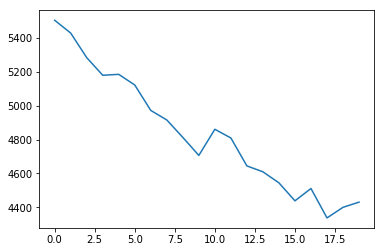

In [23]:
import time
# add timing for train
def logging(f):
    def _f(**kargs):
        print(f"PARMS: {kargs}")
        current = time.time()
        result = f(**kargs)
        print(f"TIME: {(time.time() - current):.3f} seconds")
        return result
    return _f

@logging
def train(lr=0.001, epochs=10, proj=256, hidden=128, num_layers=4, device='cuda', opt='Adam', debug=False):
    # define net, loss, optimizer
    device = torch.device(device)
    N = 100
    M = 6
    embedder_net = SpeechEmbedder(hidden=hidden, num_layers=num_layers, proj=proj, N=N, M=M).to(device)
    criterion = GE2ELoss(device)
    if opt == 'Adam':
        optimizer = torch.optim.Adam([{'params': embedder_net.parameters()},
                                 {'params': criterion.parameters()}], lr=lr)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD([{'params': embedder_net.parameters()},
                                    {'params': criterion.parameters()}], lr=lr)
    # print(f"Your optimizer is {optimizer}")
    train_dataset = SpeakerDatasetTIMITPreprocessed('./train_tisv/', M)
    train_loader = DataLoader(train_dataset, batch_size=N, drop_last=True, shuffle=True)
    # print(len(train_loader))
    # train network
    epochs = epochs
    loss_log = []
    for e in range(epochs):
        epoch_loss = 0
        for batch_id, mel_db in enumerate(train_loader):
            # we have only 270 people the batch size is 1.
            mel_db = mel_db.to(device)
            mel_db = mel_db.reshape(N * M, mel_db.size(2), mel_db.size(3))
            optimizer.zero_grad()
            embeddings = embedder_net(mel_db)
            loss = criterion(embeddings)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if debug:
                print(batch_id, epoch_loss)
        loss_log.append(epoch_loss)
    if debug:
        plt.plot(loss_log)
    if not os.path.exists('./models'):
        os.makedirs('./models')
    save_model_path = f'./models/lr{lr}epochs{epochs}proj{proj}hidden{hidden}num_layers{num_layers}opt{opt}.model'
    torch.save(embedder_net.state_dict(), save_model_path)
    return save_model_path, loss_log

# test loss printout
train(epochs=20)

# 增加testing EER

PARMS: {'lr': 0.001, 'epochs': 100, 'proj': 64, 'hidden': 128, 'num_layers': 3}
TIME: 43.653 seconds
torch.Size([30, 3, 30])

EER : 0.17 (thres:0.50, FAR:0.14, FRR:0.20)
torch.Size([30, 3, 30])

EER : 0.14 (thres:0.50, FAR:0.14, FRR:0.14)
torch.Size([30, 3, 30])

EER : 0.13 (thres:0.50, FAR:0.12, FRR:0.14)
torch.Size([30, 3, 30])

EER : 0.11 (thres:0.51, FAR:0.12, FRR:0.10)
torch.Size([30, 3, 30])

EER : 0.18 (thres:0.50, FAR:0.17, FRR:0.19)
torch.Size([30, 3, 30])

EER : 0.20 (thres:0.50, FAR:0.15, FRR:0.24)
torch.Size([30, 3, 30])

EER : 0.16 (thres:0.50, FAR:0.14, FRR:0.19)
torch.Size([30, 3, 30])

EER : 0.19 (thres:0.50, FAR:0.16, FRR:0.22)
torch.Size([30, 3, 30])

EER : 0.14 (thres:0.51, FAR:0.14, FRR:0.13)
torch.Size([30, 3, 30])

EER : 0.16 (thres:0.50, FAR:0.13, FRR:0.20)


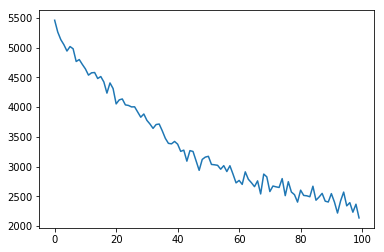

In [33]:
def test(model_path, **kargs):
    # test network
    N = 30
    M = 6
    test_dataset = SpeakerDatasetTIMITPreprocessed('./test_tisv/', M)
    test_loader = DataLoader(test_dataset, batch_size=N, drop_last=True, shuffle=True)
    embedder_net = SpeechEmbedder(40, kargs['hidden'], kargs['num_layers'], kargs['proj'], N, M//2)
    embedder_net.load_state_dict(torch.load(model_path))
    device = torch.device('cuda')
    embedder_net.to(device)
    embedder_net.eval()
    epochs = 10
    acc = 0 
    for e in range(epochs):
        batch_avg_EER = 0
        for batch_id, mel_db in enumerate(test_loader):
            mel_db = mel_db.to(device)
            utt_num = mel_db.shape[1]
            assert utt_num % 2 == 0
            enrollment, verification = torch.split(mel_db, utt_num // 2, dim=1)
            enrollment = embedder_net(enrollment.reshape(-1, mel_db.size(2), mel_db.size(3)))
            verification = embedder_net(verification.reshape(-1, mel_db.size(2), mel_db.size(3)))
            enrollment_centroids = get_centroids(enrollment)
            # verification = get_centroids(verification)
            sim_matrix = get_cossim(verification, enrollment_centroids)
            # print(sim_matrix.shape) # 30 3 
            # calculating EER
            diff = 1; EER=0; EER_thresh = 0; EER_FAR=0; EER_FRR=0
            
            for thres in [0.01*i+0.5 for i in range(50)]:
                sim_matrix_thresh = sim_matrix>thres
                
                FAR = (sum([sim_matrix_thresh[i].float().sum()-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(N))])
                /(N-1.0)/(float(M/2))/N)
    
                FRR = (sum([M/2-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(N))])
                /(float(M/2))/N)
                
                # Save threshold when FAR = FRR (=EER)
                if diff> abs(FAR-FRR):
                    diff = abs(FAR-FRR)
                    EER = (FAR+FRR)/2
                    EER_thresh = thres
                    EER_FAR = FAR
                    EER_FRR = FRR
            batch_avg_EER += EER
            print("\nEER : %0.2f (thres:%0.2f, FAR:%0.2f, FRR:%0.2f)"%(EER,EER_thresh,EER_FAR,EER_FRR))
#             result = cosine_distances(verification.detach().cpu().numpy(),enrollment.detach().cpu().numpy())
#             batch_acc = sum(list(range(N)) == result.argmin(0)) / N
#             acc += batch_acc
#             print(f"BATCH ACC:{batch_acc}")
    return acc/10


def pipeline(**params):
    # training
    model_path, total_loss = train(lr=params['lr'], 
                       epochs=params['max_epochs'], 
                       proj=params['proj'], 
                       hidden=params['hidden'], 
                       num_layers=params['num_layers'])
    plt.plot(total_loss)
    # testing
    acc = test(model_path, 
         proj=params['proj'], 
         hidden=params['hidden'], 
         num_layers=params['num_layers'])
    return acc

# test pipleline
pipeline(lr=0.001, max_epochs=100, proj=64, hidden=128, num_layers=3)

PARMS: {'lr': 0.001, 'epochs': 30, 'proj': 128, 'hidden': 128, 'num_layers': 3}
TIME: 7.133 seconds
BATCH ACC:0.36666666666666664
BATCH ACC:0.4
BATCH ACC:0.43333333333333335
BATCH ACC:0.4666666666666667
BATCH ACC:0.2
BATCH ACC:0.43333333333333335
BATCH ACC:0.2
BATCH ACC:0.26666666666666666
BATCH ACC:0.4666666666666667
BATCH ACC:0.3333333333333333
acc:0.3566666666666667
MAX ACC: 0.3566666666666667
PARMS: {'lr': 0.001, 'epochs': 100, 'proj': 128, 'hidden': 128, 'num_layers': 3}
TIME: 23.756 seconds
BATCH ACC:0.5
BATCH ACC:0.5333333333333333
BATCH ACC:0.4666666666666667
BATCH ACC:0.6666666666666666
BATCH ACC:0.5666666666666667
BATCH ACC:0.6666666666666666
BATCH ACC:0.6333333333333333
BATCH ACC:0.43333333333333335
BATCH ACC:0.5333333333333333
BATCH ACC:0.6
acc:0.5599999999999999
MAX ACC: 0.5599999999999999
PARMS: {'lr': 0.002, 'epochs': 30, 'proj': 128, 'hidden': 128, 'num_layers': 3}
TIME: 7.006 seconds
BATCH ACC:0.3
BATCH ACC:0.43333333333333335
BATCH ACC:0.23333333333333334
BATCH ACC:0.

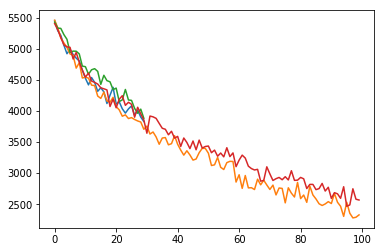

In [42]:
# parameters sets
parameters = {
'max_epochs':[30, 100],
'lr':[0.001, 0.002],
'proj':[128],
'hidden':[128],
'num_layers':[3]
}
grid = ParameterGrid(parameters)
max_acc = 0
result = pd.DataFrame(grid)

for i, params in enumerate(grid):
    acc = pipeline(lr=params['lr'], max_epochs=params['max_epochs'], proj=params['proj'], 
                   hidden=params['hidden'], num_layers=params['num_layers'])
    print(f"acc:{acc}")
    result.loc[i, 'acc'] = acc
    if acc > max_acc:
        max_acc = acc
        print(f"MAX ACC: {max_acc}")
        best_param = params
print(max_acc)
result.to_csv(f'log.csv')